In [1]:
from turbolence import *
turbolenceFormulas.displayAll()

# R_q = sp.Function("R")(r)
#R_q = sp.Function("\U0000211B_q")(r)

Eq(Re, L_0*V_0/\nu_0)

Eq(l_0, L_0/Re**(3/4))

Eq(r_0, (((0.423*k**2)/cos(\gamma))*Integral(C_N(h), (h, 0, oo)))**(-3/5))

Eq(D_phi(δx, δt), 6.88*Abs(v*δt - δx)**(7505999378950827/4503599627370496)/r_0**(7505999378950827/4503599627370496))

Eq(D_phi(r), 6.88*(r/r_0)**(5/3))

Eq(D_phi(r), 4*2**(2/3)*3**(5/6)*5**(1/6)*L_0**(5/3)*(2**(5/6)*gamma(5/6)/2 - 2**(5/6)*pi**(5/6)*r**(5/6)*besselk(5/6, 2*pi*r/L_0)/L_0**(5/6))*gamma(6/5)**(5/6)*gamma(11/6)/(5*pi**(8/3)*r_0**(5/3)))

Eq(C_phi(r), 4*sqrt(2)*3**(5/6)*5**(1/6)*L_0**(5/6)*r**(5/6)*besselk(5/6, 2*pi*r/L_0)*gamma(6/5)**(5/6)*gamma(11/6)/(5*pi**(11/6)*r_0**(5/3)))

Eq(P_phi(k), k**(-11/3)*(0.0229*r_0**(-5/3)))

Eq(P_phi(k), (0.0229*r_0**(-5/3))*(k**2 + (2*pi/L_0)**2)**(-11/6))

Eq(W_phi(f), (0.0229*r_0**(-5/3))*((1/L_0)**2 + f**2)**(-11/6))

Eq(P_phi(k), ((0.0229*r_0**(-5/3))*(k**2 + (2*pi/L_0)**2)**(-11/6))*exp(-((k*l_0)/5.92)**2))

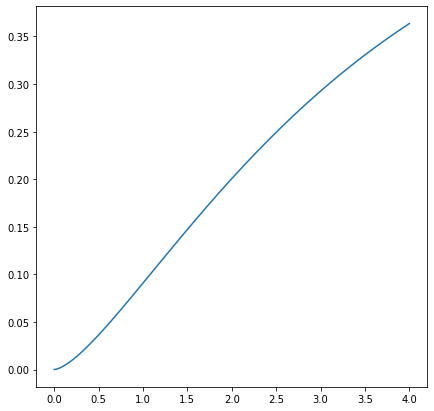

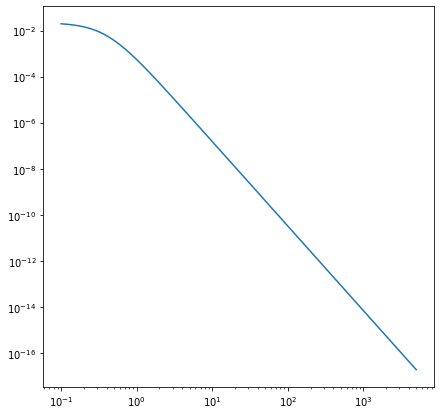

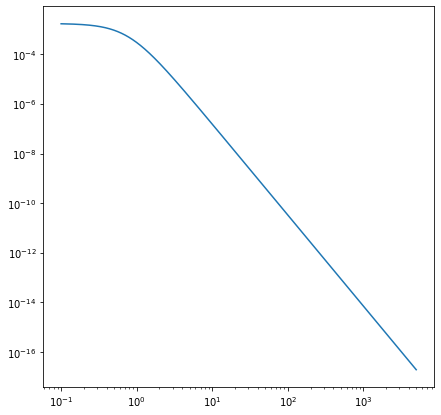

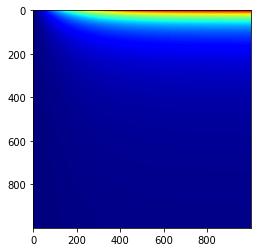

In [2]:
turbolenceFormulas.plotFormula('phaseStructureFunction', {'r_0':8.0, 'L_0':16}, ['r'],
                               [np.linspace(0.0, 4.0, 1000)+1e-40], scipyext)
turbolenceFormulas.plotFormula('phaseSpatialPowerSpectrumVonKarman', {'r_0':8.0, 'L_0':16, 'l_0':0.000001}, ['k'],
                               [np.geomspace(0.1, 5000, 10000)], scipyext, log=True)
turbolenceFormulas.plotFormula('phaseSpatialPowerSpectrumVonKarmanO', {'r_0':8.0, 'L_0':8}, ['k'],
                               [np.geomspace(0.1, 5000, 10000)], scipyext, log=True)
turbolenceFormulas.plotFormula('phaseStructureFunction', {'L_0':16}, ['r', 'r_0'],
                               [np.linspace(0.0, 16.0, 1000)+1e-40, np.linspace(1.0, 16.0, 1000)], scipyext)

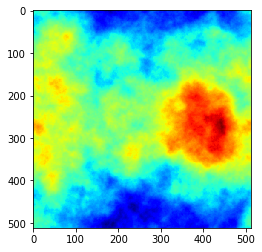

In [3]:
NN = 512
pixel_scale = 8.2/float(NN)
plt.imshow( ft_phase_screen(8.0, NN, pixel_scale, 16, 0.005), cmap='jet')

In [4]:
def seeing_to_r0(seeing, lamda=500.E-9):
    return 0.98*lamda/(seeing*np.pi/(180.*3600.))

In [5]:
from scipy.special import gamma, kv
from scipy.interpolate import interp2d

def find_allowed_size(mx_size):
    n = 0
    while (2 ** n + 1) < mx_size:
        n += 1
    mx_size = 2 ** n + 1
    return mx_size    

class PhaseScreen(object):
    def __init__(self, mx_size, pixel_scale, r0, L0, l0, xp=np, random_seed=None, stencil_length_factor=4):
        self.requested_mx_size = mx_size
        self.mx_size = find_allowed_size(mx_size)
        self.pixel_scale = pixel_scale
        self.r0 = r0
        self.L0 = L0
        self.l0 = l0
        self.xp = xp
        self.stencil_length_factor = stencil_length_factor
        self.stencil_length = stencil_length_factor * self.mx_size
        if random_seed is not None:
            self.xp.random.seed(random_seed)
        # Coordinate of Fried's "reference point" that stops the screen diverging
        self.reference_coord = (1, 1)
        self.set_stencil_coords()     
        self.setup()

    def append(self, arr, values, axis=None):
        arr = self.xp.asanyarray(arr)
        if axis is None:
            if arr.ndim != 1:
                arr = arr.ravel()
            values = self.xp.ravel(values)
            axis = arr.ndim-1
        return self.xp.concatenate((self.xp.asarray(arr), self.xp.asarray(values)), axis=axis)


    def phase_covariance(self, r, r0, L0):
        # Make sure everything is a float to avoid nasty surprises in division!
        if self.xp==cp:
            r = self.xp.asnumpy(r)
        r0 = float(r0)
        L0 = float(L0)
        # Get rid of any zeros
        r += 1e-40
        A = (L0 / r0) ** (5. / 3)
        B1 = (2 ** (-5. / 6)) * gamma(11. / 6) / (self.xp.pi ** (8. / 3))
        B2 = ((24. / 5) * gamma(6. / 5)) ** (5. / 6)
        C = (((2 * self.xp.pi * r) / L0) ** (5. / 6)) * kv(5. / 6, (2 * self.xp.pi * r) / L0)
        cov = A * B1 * B2 * C
        cov = self.xp.asarray(cov)
        return cov

    def set_stencil_coords(self):
        self.stencil = self.xp.zeros((self.stencil_length, self.mx_size))
        self.stencil[:4] = 1
        self.stencil_coords = self.xp.array(self.xp.where(self.stencil==1)).T
        self.stencil_positions = self.stencil_coords * self.pixel_scale
        self.n_stencils = len(self.stencil_coords)

    def setup(self):        
        # set X coords
        self.X_coords = self.xp.zeros((self.mx_size, 2))
        self.X_coords[:, 0] = -1
        self.X_coords[:, 1] = self.xp.arange(self.mx_size)
        self.X_positions = self.X_coords * self.pixel_scale
        
        # calc separations
        positions = self.append(self.stencil_positions, self.X_positions, axis=0)
        self.seperations = self.xp.zeros((len(positions), len(positions)))
        
        px, py = positions[:,0], positions[:,1]
        delta_x_gridA, delta_x_gridB = self.xp.meshgrid(px, px)        
        delta_y_gridA, delta_y_gridB = self.xp.meshgrid(py, py)        
        delta_x_grid = delta_x_gridA - delta_x_gridB     
        delta_y_grid = delta_y_gridA - delta_y_gridB     
        self.seperations = self.xp.sqrt(delta_x_grid ** 2 + delta_y_grid ** 2)

        # make cov_mats
        self.cov_mat = self.phase_covariance(self.seperations, self.r0, self.L0)
        self.cov_mat_zz = self.cov_mat[:self.n_stencils, :self.n_stencils]
        self.cov_mat_xx = self.cov_mat[self.n_stencils:, self.n_stencils:]
        self.cov_mat_zx = self.cov_mat[:self.n_stencils, self.n_stencils:]
        self.cov_mat_xz = self.cov_mat[self.n_stencils:, :self.n_stencils]
        # make A
        # Cholesky solve can fail - if so do brute force inversion
        if self.xp == np:
            try:
                cf = scipy.linalg.cho_factor(self.cov_mat_zz)
                inv_cov_zz = scipy.linalg.cho_solve(cf, self.xp.identity(self.cov_mat_zz.shape[0]))
            except scipy.linalg.LinAlgError:
                raise scipy.linalg.LinAlgError("Could not invert Covariance Matrix to for A and B Matrices. Try with a larger pixel scale")
        else:
                cf = cupyx.scipy.linalg.lu_factor(self.cov_mat_zz)
                inv_cov_zz = cupyx.scipy.linalg.lu_solve(cf, self.xp.identity(self.cov_mat_zz.shape[0]))
            
        self.A_mat = self.cov_mat_xz.dot(inv_cov_zz)
        # make B
        # Can make initial BBt matrix first
        BBt = self.cov_mat_xx - self.A_mat.dot(self.cov_mat_zx)
        # Then do SVD to get B matrix
        u, W, ut = self.xp.linalg.svd(BBt)
        L_mat = self.xp.zeros((self.mx_size, self.mx_size))
        self.xp.fill_diagonal(L_mat, self.xp.sqrt(W))
        # Now use sqrt(eigenvalues) to get B matrix
        self.B_mat = u.dot(L_mat)
        # make initial screen
        self._scrn = ft_phase_screen( self.r0, self.stencil_length, self.pixel_scale, self.L0, self.l0 )        
        self._scrn = self._scrn[:, :self.mx_size]
   
    def get_new_row(self):
        random_data = self.xp.random.normal(size=self.mx_size) / ((2*self.xp.pi)**2)
        stencil_data = self.xp.asarray(self._scrn[cp.asnumpy(self.stencil_coords[:, 0]), cp.asnumpy(self.stencil_coords[:, 1])])
        new_row = self.A_mat.dot(stencil_data) + self.B_mat.dot(random_data)
        self.xp.reshape( new_row, (1, self.mx_size) )
        return self.xp.asarray(new_row)
    
    def add_row(self):
        new_row = self.get_new_row()
        self._scrn = self.append([new_row], self._scrn, axis=0)[:self.stencil_length, :self.mx_size]
        return self.xp.asarray(self.scrn)

    def __repr__(self):
        return str(self.scrn)

    @property
    def scrn(self):
        return cp.asnumpy(self._scrn[:self.requested_mx_size, :self.requested_mx_size])


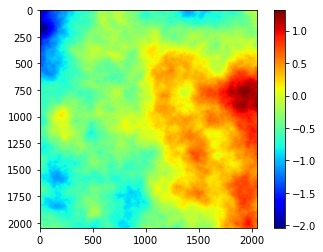

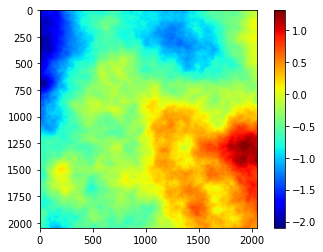

In [6]:
NN = 1024*2
pixel_scale = 8.2/float(NN)
scrn = PhaseScreen(NN, pixel_scale, seeing_to_r0(0.8), 20, 0.005, np)

plt.imshow(scrn.scrn, cmap='jet')
plt.colorbar()
plt.show()
for i in range(NN//4):
    scrn.add_row()
    
plt.imshow(scrn.scrn, cmap='jet')
plt.colorbar()
plt.show()

In [7]:
%%timeit     
scrn.add_row()

62.8 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


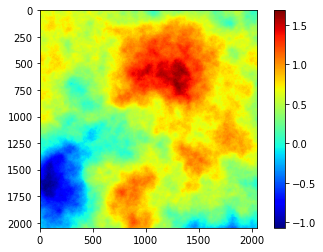

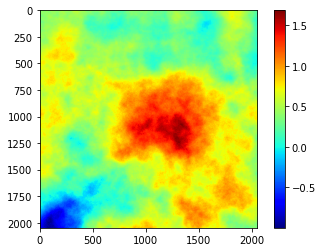

In [8]:
NN = 1024*2
pixel_scale = 8.2/float(NN)
scrn = PhaseScreen(NN, pixel_scale, seeing_to_r0(0.8), 20, 0.005, cp)

plt.imshow(scrn.scrn, cmap='jet')
plt.colorbar()
plt.show()

for i in range(NN//4):
    scrn.add_row()
    
plt.imshow(scrn.scrn, cmap='jet')
plt.colorbar()
plt.show()

In [9]:
%%timeit     
scrn.add_row()

26.8 ms ± 72 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# REAL stuff ends here!!!!

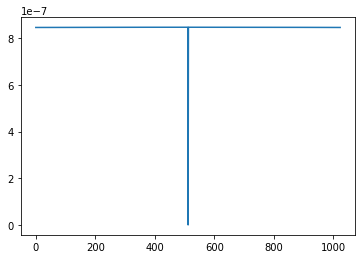

In [11]:
NN = 1024
pixel_scale = 50.0/float(NN)
psd2d = ft_PSD_phi(8, NN, pixel_scale, 1.0, 1e1-10)
psd2ds = np.fft.fftshift(psd2d)
#plt.imshow( psd2d, cmap='jet')
plt.xscale('linear')
plt.yscale('linear')
plt.plot(psd2d[0][:, int(NN//2)])
plt.show()

In [12]:
eeq = turbolenceFormulas.getFormula('phaseStructureFunctionOrig_r')

free_syms = { symbol.name:symbol for symbol in eeq.rhs.free_symbols }    
k, r = sp.symbols('k r', positive=True)
# ft = sp.HankelTransform(sp.simplify(rh), free_syms['r'], k, 0)
#r = free_syms['r']
expr = 1/ k** (sp.S(11)/sp.S(6))
display(expr)
ft = sp.InverseHankelTransform( expr, k, r, sp.S(0))
iii = ft.rewrite(sp.Integral)
display(iii)
res = ft.doit(noconds=True) 
print(res)
display(res)


kk =33
k0 = kk+1
max_n = 1
while True:
    if 2 ** (max_n - 1) + 1 >= kk:
        max_n -= 1
        break
    max_n += 1
print(max_n)

k**(-11/6)

Integral(besselj(0, k*r)/k**(5/6), (k, 0, oo))

2**(1/6)*gamma(1/12)/(2*r**(1/6)*gamma(11/12))


2**(1/6)*gamma(1/12)/(2*r**(1/6)*gamma(11/12))

5


In [13]:
kk =33
print( int(np.ceil(np.log2(kk-1) )) )

5


[0]


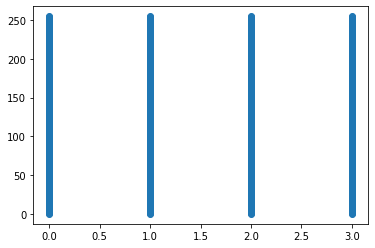

In [14]:
mx_size = 256
pixel_scale = 1
stencil_length_factor = 4
stencil_length = stencil_length_factor * mx_size
stencil = np.zeros((stencil_length, mx_size))
        
max_n = int(np.ceil(np.log2(mx_size-1) )) 

for n in range(0, max_n + 1):
    col = int((2 ** (n - 1)) + 1)
    n_points = (2 ** (max_n - n)) + 1
    coords = np.round(np.linspace(0, mx_size - 1, n_points)).astype('int64')
    stencil[col - 1][coords] = 1
# Now fill in tail of stencil
for n in range(1, stencil_length_factor + 1):
    col = n * mx_size - 1
    stencil[col, mx_size // 2] = 1

    
    

stencil = np.zeros((stencil_length, mx_size))

stencil[0:4] = 1
    
    
    
stencil_coords = np.array(np.where(stencil == 1)).T
stencil_positions = stencil_coords * pixel_scale
n_stencils = len(stencil_coords)

import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(stencil_positions[:,0], stencil_positions[:,1])
print(stencil_positions[0,0::2])
#fig, ax = plt.subplots(figsize=(20*2, 5*2))
#ax.imshow(stencil[0:128, :], interpolation='nearest')


In [15]:
import sympy as sp
import sympy.parsing.latex
from sympy.parsing.latex import parse_latex

expr = parse_latex(r"\frac {1 + \sqrt {\a}} {\b}")  
print( list(expr.free_symbols)[0].assumptions0 ) 

rep_dict = {}
for ss in list(expr.free_symbols):
    rep_dict[ss] = sp.symbols(ss.name, positive=True)

expr1 = expr.xreplace( rep_dict )

display(expr)
#print(dir(expr))
#expr.evalf(4, subs=dict(a=5, b=2))  

ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
{'commutative': True}


(sqrt(a) + 1)/b